# Parametric Dynamic Mode Decomposition

In this tutorial we explore the usage of the class `pydmd.ParametricDMD`, presented in *A Dynamic Mode Decomposition Extension for the Forecasting of Parametric Dynamical Systems* by Andreuzzi et all ([doi](https://doi.org/10.1137/22M1481658) ). The approach provides an extension Dynamic Mode Decomposition to parametric problems, in order to obtain predictions for future time instants in untested parameters.

We'll examine a simple parametric time-dependent problem, the sum of two complex period functions:
$$\begin{cases}
f_1(x,t) &:= e^{2.3i*t} \cosh(x+3)^{-1}\\
f_2(x,t) &:= 2 * e^{2.8j*t} \tanh(x) \cosh(x)^{-1}\\
f^{\mu}(x,t) &:= \mu f_1(x,t) + (1-\mu) f_2(x,t), \qquad \mu \in [0,1]
\end{cases}$$

### Modules
First of all we import the modules which we'll use throughout the tutorial:
+ In addition to `pydmd.ParametricDMD` we import the class `pydmd.DMD`, we'll present later how it is used;
+ The classes `POD` and `RBF` from `ezyrb`, which are used respectively to reduce the dimensionality before the interpolation and to perform the interpolation;
+ `NumPy` and `Matplotlib`.

In [1]:
import warnings

warnings.filterwarnings("ignore")

from pydmd import ParametricDMD, DMD, HankelDMD
from ezyrb import POD, RBF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
import sys
sys.path.append("..")
from dmd import BaggingOptimisedDMD

### Functions

First of all we define several functions to construct our system and gather the data needed to train the algorithm:

In [3]:
def f1(x, t):
    return 1.0 / np.cosh(x + 3) * np.exp(2.3j * t)


def f2(x, t):
    return 2.0 / np.cosh(x) * np.tanh(x) * np.exp(2.8j * t)


def f(mu, x, t):
    return mu * f1(x, t) + (1 - mu) * f2(x, t)

### Training dataset
We prepare a discrete space-time grid with an acceptable number of sample points in both the dimensions, which we'll use later on to generate our training dataset:

In [4]:
n_space = 500
n_time = 160

x = np.linspace(-5, 5, n_space)
t = np.linspace(0, 4 * np.pi, n_time)

xgrid, tgrid = np.meshgrid(x, t)

The training dataset results from applying the function `f` defined above for several known parameters. We select 10 equispaced parameters in the interval `[0,1]`. Our parameter is 1-dimensional, but _Parametric DMD_ works also with parameters living in multi-dimensional spaces.

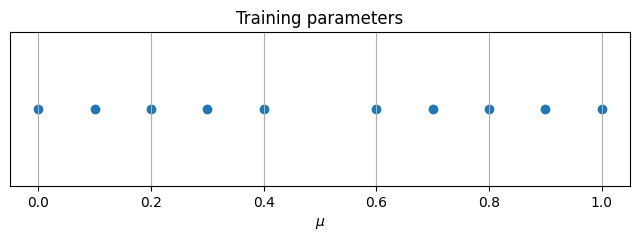

In [5]:
training_params = np.round(np.linspace(0, 1, 10), 1)

plt.figure(figsize=(8, 2))
plt.scatter(training_params, np.zeros(len(training_params)), label="training")
plt.title("Training parameters")
plt.grid()
plt.xlabel("$\mu$")
plt.yticks([], []);

It's critical to provide a sufficient number of _training_ parameters, otherwise the algorithm won't be able to explore the solution manifold in an acceptable way.

The training dataset results from the application of `f` to the combination of `xgrid`, `tgrid` and the parameters in `training_params`:

In [6]:
training_snapshots = np.stack(
    [f(x=xgrid, t=tgrid, mu=p).T for p in training_params]
)
print(training_snapshots.shape)

(10, 500, 160)


As you can see the shape of the training dataset follows the convention:
$$n_{train} \times n_{space} \times n_{time-instants}$$

In [7]:
similar_testing_params = [1, 3, 5, 7, 9]
testing_params = training_params[similar_testing_params] + np.array(
    [5 * pow(10, -i) for i in range(2, 7)]
)
testing_params_labels = [
    str(training_params[similar_testing_params][i - 2])
    + "+$5*10^{{-{}}}$".format(i)
    for i in range(2, 7)
]

time_step = t[1] - t[0]
N_predict = 40
N_nonpredict = 40

t2 = np.array(
    [4 * np.pi + i * time_step for i in range(-N_nonpredict + 1, N_predict + 1)]
)
xgrid2, tgrid2 = np.meshgrid(x, t2)

testing_snapshots = np.array(
    [f(mu=p, x=xgrid2, t=tgrid2).T for p in testing_params]
)

### Utility functions
We define a few utiliy functions to ease the explanation in the following paragraphs, you can ignore safely the following code if you'd like.

In [8]:
def title(param):
    return "$\mu$={}".format(param)


def visualize(X, param, ax, log=False, labels_func=None):
    ax.set_title(title(param))
    if labels_func != None:
        labels_func(ax)
    if log:
        return ax.pcolormesh(
            X.real.T, norm=colors.LogNorm(vmin=X.min(), vmax=X.max())
        )
    else:
        return ax.pcolormesh(X.real.T)


def visualize_multiple(
    Xs, params, log=False, figsize=(20, 6), labels_func=None
):
    if log:
        Xs[Xs == 0] = np.min(Xs[Xs != 0])

    fig = plt.figure(figsize=figsize)

    axes = fig.subplots(nrows=1, ncols=5, sharey=True)

    if labels_func is None:

        def labels_func_default(ax):
            ax.set_yticks([0, n_time // 2, n_time])
            ax.set_yticklabels(["0", "$\pi$", "2$\pi$"])

            ax.set_xticks([0, n_space // 2, n_space])
            ax.set_xticklabels(["-5", "0", "5"])

        labels_func = labels_func_default

    im = [
        visualize(X, param, ax, log, labels_func)
        for X, param, ax in zip(Xs, params, axes)
    ][-1]

    fig.colorbar(im, ax=axes)
    plt.show()

We can use the functions defined in the last code block to visualize our data for some training parameters:

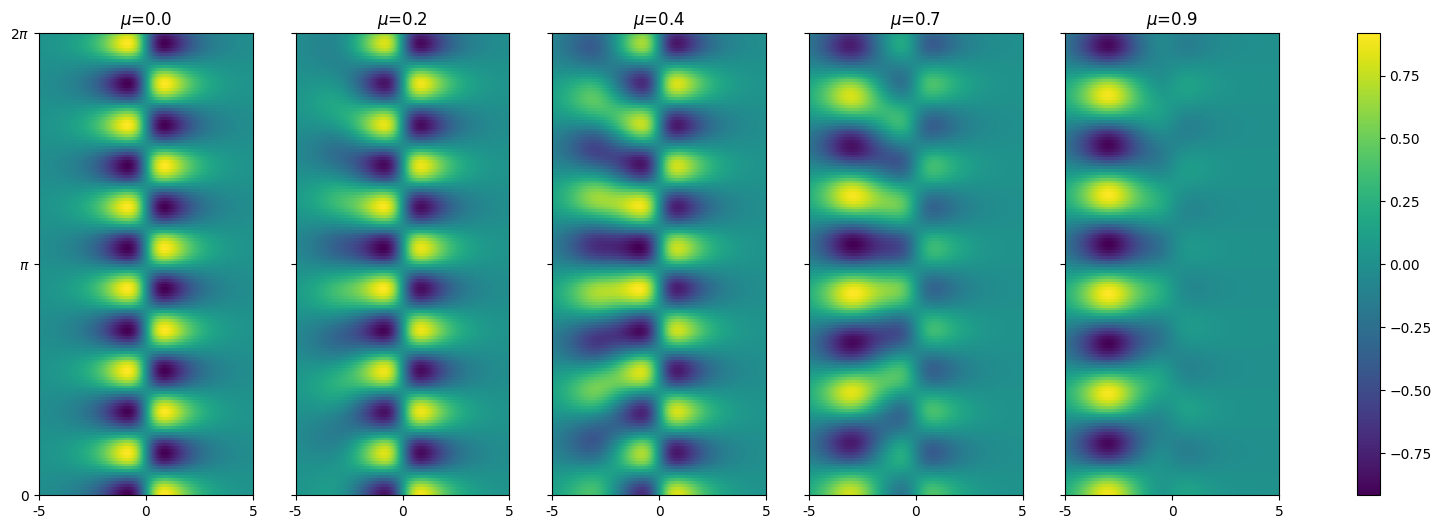

In [9]:
idxes = [0, 2, 4, 6, 8]
visualize_multiple(training_snapshots[idxes], training_params[idxes])

pydmd

In [10]:
dmd = DMD(svd_rank=-1)
rom = POD(rank=20)
interpolator = RBF()

pdmd_monolithic = ParametricDMD(dmd, rom, interpolator)

dmds = [DMD(svd_rank=-1) for _ in range(len(training_params))]
pdmd_partitioned = ParametricDMD(dmds, rom, interpolator)

pdmd_monolithic.fit(
    training_snapshots, training_params
)  # same for pdmd_partitioned

pdmd_partitioned.fit(
    training_snapshots, training_params
)

My implementation

(0.0, 30.0)

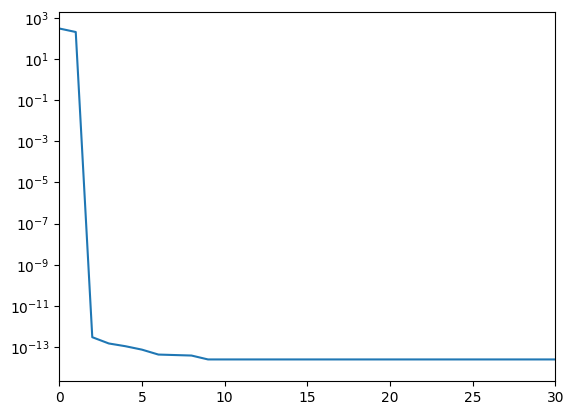

In [11]:
_, s, _ = np.linalg.svd(np.transpose(training_snapshots, (0,2,1)).reshape(-1, n_space).T, full_matrices=False)

plt.semilogy(s)
plt.xlim(0,30)

In [45]:
parametric_dict = {
        'mode': 'monolithic',
        'train_params': training_params,
        'test_params': testing_params
}

bopdmd = BaggingOptimisedDMD(2, num_trials=5, 
                             parametric=parametric_dict)

bopdmd.train(training_snapshots, t)

In [46]:
# idx = -1

# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs[0].contourf(xgrid, tgrid, training_snapshots[idx].real.T, levels=100)
# axs[1].contourf(xgrid, tgrid, bopdmd.dmd._spatial_pod.expand(bopdmd._dmd[idx].reconstructed_data).real.T, levels=100)
# cont = axs[2].contourf(xgrid, tgrid, np.abs(bopdmd.dmd._spatial_pod.expand(bopdmd._dmd[idx].reconstructed_data).real.T - training_snapshots[idx].real.T), levels=100)
# fig.colorbar(cont, ax=axs[2])


## Unseen parameters

### Choosing testing parameters
We select some _unknown_ (or _testing_) parameters in order to assess the results obtained using the parametric approach. We take testing parameters at dishomogeneous distances from our training parameters, which results in varying degrees of accuracy. This is pretty much what the following snippet does, you can just jump to the plot below to see the arrangement on the real line of the testing parameters:

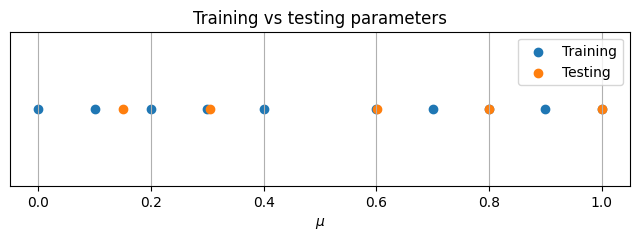

In [47]:
plt.figure(figsize=(8, 2))
plt.scatter(training_params, np.zeros(len(training_params)), label="Training")
plt.scatter(testing_params, np.zeros(len(testing_params)), label="Testing")
plt.legend()
plt.grid()
plt.title("Training vs testing parameters")
plt.xlabel("$\mu$")
plt.yticks([], []);

Notice that in our case we had the freedom to take whathever parameter we wanted to showcase our method. In practical (or _less theoretical_) application you will probably have fixed unknown parameters which you're interested to use. 

### Instructing `ParametricDMD` on which parameter it should interpolate

We can now set the testing parameters by setting the propery `parameters` of our instance of `ParametricDMD`

In [48]:
pdmd_monolithic.parameters = testing_params  # same for pdmd_partitioned
pdmd_partitioned.parameters = testing_params

We also show that we can predict future values out of the time window provided during the training:

In [49]:
pdmd_monolithic.dmd_time["t0"] = (
    pdmd_monolithic.original_time["tend"] - N_nonpredict + 1
)
pdmd_monolithic.dmd_time["tend"] = (
    pdmd_monolithic.original_time["tend"] + N_nonpredict
)

pdmd_partitioned.dmd_time["t0"] = (
    pdmd_partitioned.original_time["tend"] - N_nonpredict + 1
)
pdmd_partitioned.dmd_time["tend"] = (
    pdmd_partitioned.original_time["tend"] + N_nonpredict
)

print(
    f"ParametricDMD will compute {len(pdmd_monolithic.dmd_timesteps)} timesteps:",
    pdmd_monolithic.dmd_timesteps * time_step,
)

ParametricDMD will compute 80 timesteps: [ 9.48405329  9.56308707  9.64212085  9.72115463  9.8001884   9.87922218
  9.95825596 10.03728974 10.11632351 10.19535729 10.27439107 10.35342485
 10.43245862 10.5114924  10.59052618 10.66955996 10.74859373 10.82762751
 10.90666129 10.98569507 11.06472884 11.14376262 11.2227964  11.30183018
 11.38086395 11.45989773 11.53893151 11.61796528 11.69699906 11.77603284
 11.85506662 11.93410039 12.01313417 12.09216795 12.17120173 12.2502355
 12.32926928 12.40830306 12.48733684 12.56637061 12.64540439 12.72443817
 12.80347195 12.88250572 12.9615395  13.04057328 13.11960706 13.19864083
 13.27767461 13.35670839 13.43574217 13.51477594 13.59380972 13.6728435
 13.75187728 13.83091105 13.90994483 13.98897861 14.06801239 14.14704616
 14.22607994 14.30511372 14.3841475  14.46318127 14.54221505 14.62124883
 14.70028261 14.77931638 14.85835016 14.93738394 15.01641772 15.09545149
 15.17448527 15.25351905 15.33255283 15.4115866  15.49062038 15.56965416
 15.64868793

## Results

You can extract results from `ParametricDMD` as follows:

In [50]:
idx = 0

result_pydmd_mono = pdmd_monolithic.reconstructed_data[idx]
result_pydmd_part = pdmd_partitioned.reconstructed_data[idx]

In [51]:
result_pydmd_part.shape

(500, 80)

In [52]:
results_bopdmd = bopdmd.predict(pdmd_monolithic.dmd_timesteps * time_step)

In [53]:
results_bopdmd.shape

(500, 80)

### Results analysis
First of all we visualize the results and the associated point-wise error:

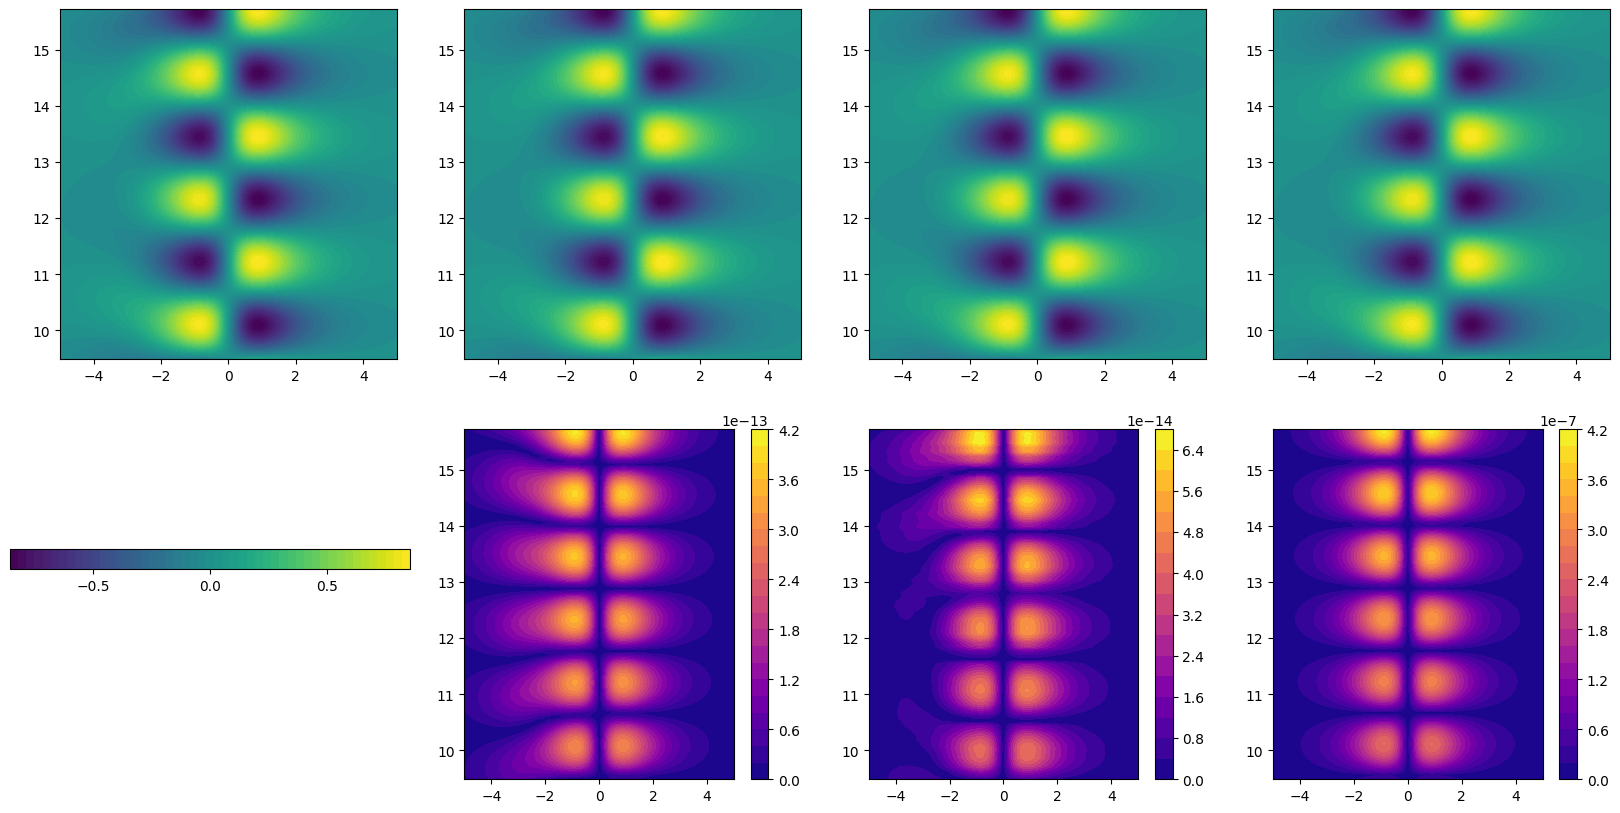

In [54]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

axs[1,0].axis('off')

levels = np.linspace(testing_snapshots[idx].real.min(), testing_snapshots[idx].real.max(), 50)
cont = axs[0,0].contourf(xgrid2, tgrid2, testing_snapshots[idx].real.T, levels=levels)
cbar = fig.colorbar(cont, ax=axs[1,0], orientation='horizontal')
cbar.ax.set_position([0.1, 0.01, 0.2, 0.33])
cbar.ax.set_xticks([-0.5, 0, 0.5])

axs[0,1].contourf(xgrid2, tgrid2, result_pydmd_mono.real.T, levels=levels)
axs[0,2].contourf(xgrid2, tgrid2, result_pydmd_part.real.T, levels=levels)

axs[0,3].contourf(xgrid2, tgrid2, results_bopdmd.real.T, levels=levels)

cont = axs[1,1].contourf(xgrid2, tgrid2, np.abs(testing_snapshots[idx].real.T - result_pydmd_mono.real.T), levels=20, cmap='plasma')
fig.colorbar(cont, ax=axs[1,1])

cont = axs[1,2].contourf(xgrid2, tgrid2, np.abs(testing_snapshots[idx].real.T - result_pydmd_part.real.T), levels=20, cmap='plasma')
fig.colorbar(cont, ax=axs[1,2])

cont = axs[1,3].contourf(xgrid2, tgrid2, np.abs(testing_snapshots[idx].real.T - results_bopdmd.real.T), levels=20, cmap='plasma')
fig.colorbar(cont, ax=axs[1,3])